In [233]:
# Import required libraries
import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

In [234]:
cpiDf = pd.read_csv(
    Path("resources/foodPrice.csv")
)

cpiDf.head()
cpiDf.rename({'Dairy-and-related-products': 'Dairy-products'},axis='columns',inplace = True)
cats = cpiDf.columns.to_list()
cats = [i.replace('-',' ') for i in cats if i != 'Date']
cpiDf['Date'] = pd.to_datetime(cpiDf['Date'])
cpiDf.head()

,Cereals-and-bakery-products,"Meats,-poultry,-fish,-and-eggs",Dairy-products,Fruits-and-vegetables,Other-food-at-home,Date
0,79.7,90.4,87.3,76.5,83.0,1980-01-01
1,80.6,89.7,87.8,76.0,84.3,1980-02-01
2,81.2,90.3,88.1,77.4,85.5,1980-03-01
3,82.4,89.3,88.9,80.2,86.4,1980-04-01
4,83.2,88.0,90.5,82.1,87.3,1980-05-01


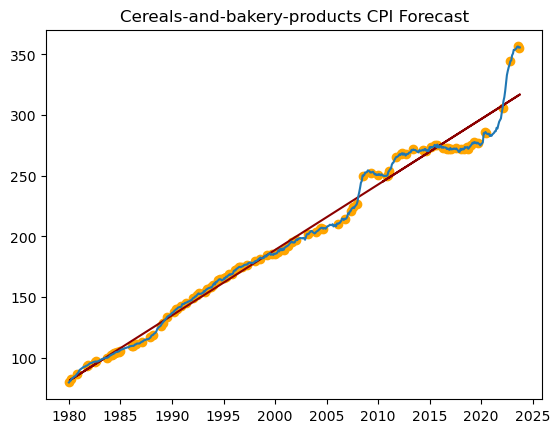

0.9791065545583285
Root mean squared error: 9.953684742512104
Mean absolute error: 6.9865877967124295


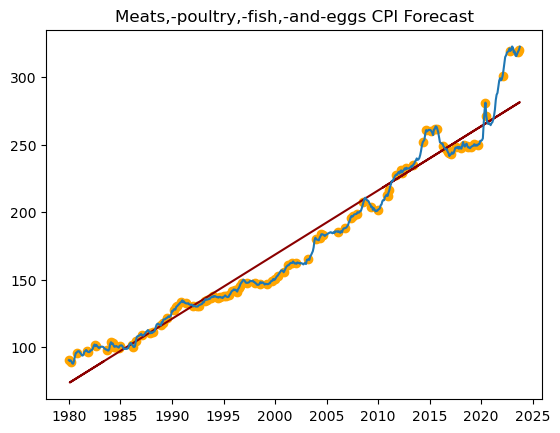

0.9545028859004849
Root mean squared error: 13.25640550004063
Mean absolute error: 10.11824760435221


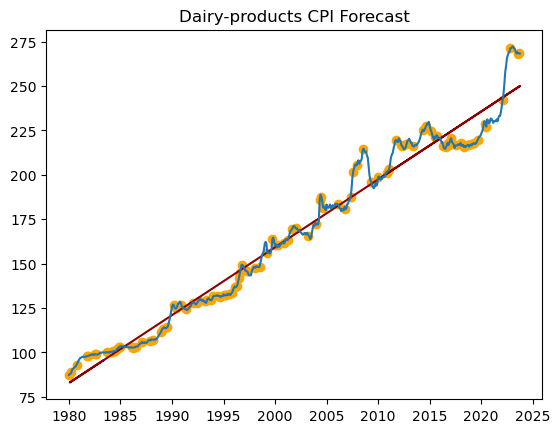

0.9716245887118619
Root mean squared error: 8.305021156561383
Mean absolute error: 6.413218134706657


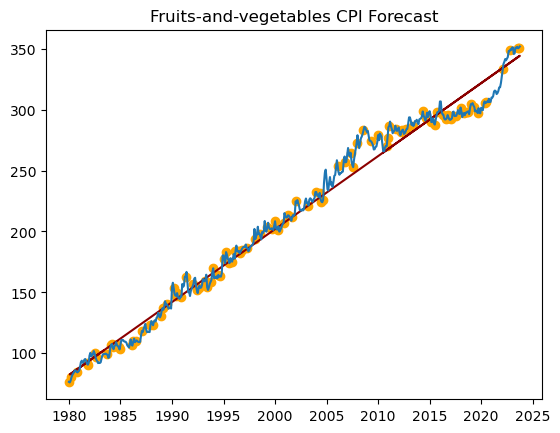

0.9827105517885026
Root mean squared error: 10.084791382637954
Mean absolute error: 7.762663779739292


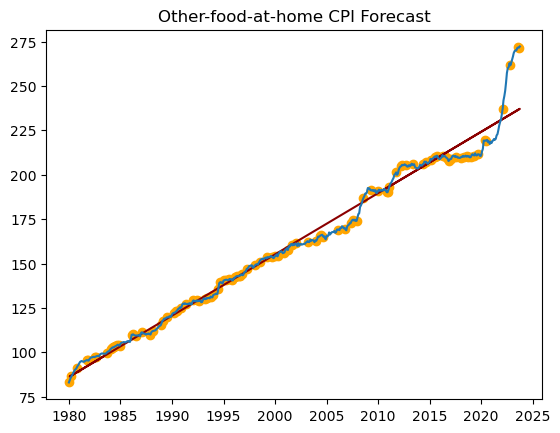

0.9743733400898358
Root mean squared error: 7.0972118091995595
Mean absolute error: 4.164102343366228


In [265]:

model = LinearRegression()
for cat in cpiDf.columns:
    if cat != 'Date':
        # plt.plot(cpiDf['Date'],cpiDf[cat])
        X = cpiDf['Date'].values.astype("float64").reshape(-1,1)
        y = cpiDf[cat]
        X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=.2,random_state = 4)
        # X_train = cpiDf['Date'].values.astype("float64").reshape(-1,1)
        # y_train = cpiDf[cat]
        model.fit(X_train,y_train)

        preds = model.predict(X_test)
        # # Display the prediction
        # samp = pd.DataFrame(cpiDf[['Date',cat]].copy())
        # samp['Prediction'] = preds

        plt.plot(pd.to_datetime(X_test.reshape(-1)),preds,color='darkred')
        plt.plot(pd.to_datetime(X.reshape(-1)),y)
        plt.scatter(pd.to_datetime(X_train.reshape(-1)),y_train,color='orange')
        plt.title(f'{cat} CPI Forecast')
        plt.show()

        print(model.score(X_test,y_test))
        mse = mean_squared_error(y_test,preds,squared = False)
        print(f'Root mean squared error: {mse}')
        mae = mean_absolute_error(y_test,preds)
        print(f'Mean absolute error: {mae}')

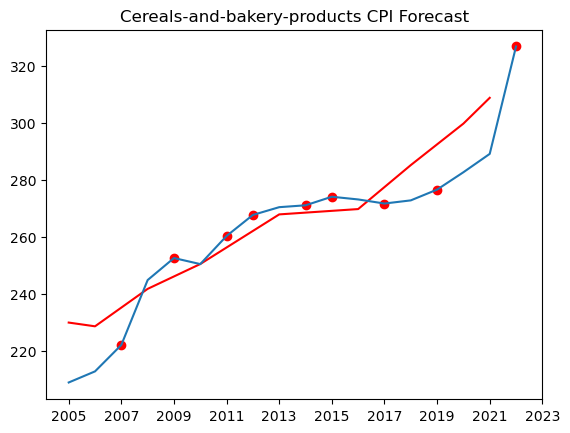

0.7729894170308064
Root mean squared error: 13.112991158415099
Mean absolute error: 10.542163582882965


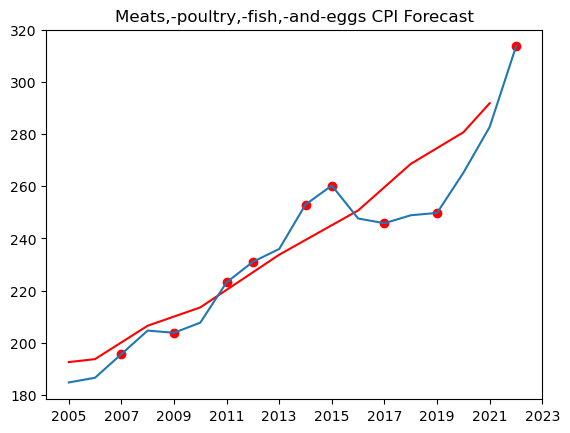

0.9107530640402934
Root mean squared error: 9.862798401665705
Mean absolute error: 8.028407007870552


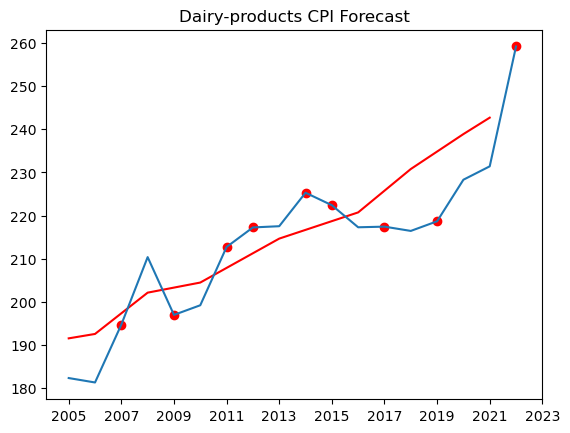

0.7082852782496614
Root mean squared error: 9.254303070196736
Mean absolute error: 8.4916453999476


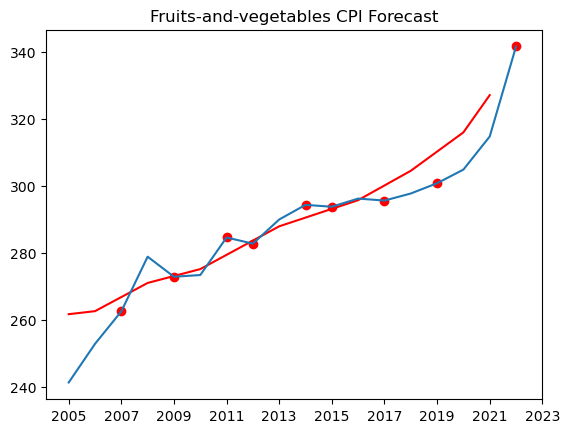

0.8074752442440329
Root mean squared error: 10.004813006723124
Mean absolute error: 8.052296699291373


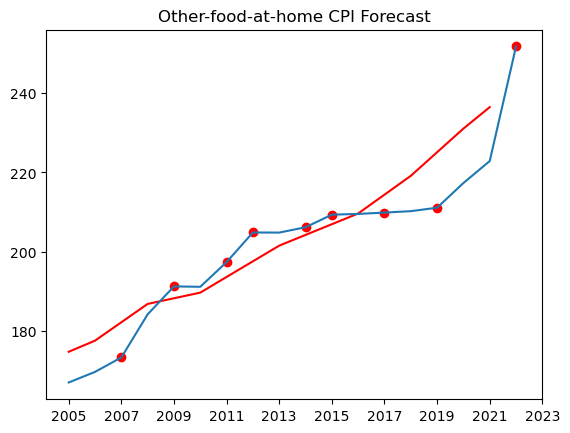

0.8206642490041249
Root mean squared error: 8.139011830642795
Mean absolute error: 6.60343764937324


In [261]:
## testing out multiple regression

fin = pd.DataFrame()
for year in np.arange(2005,2022+1):
    spendDf = pd.read_csv(Path(f"resources/spending_{year}.csv"),index_col = 'Item')
    spendDf.drop(columns='Year',inplace=True)
    spendDf = spendDf.loc[cats].T
    spendDf = spendDf.reset_index().rename({'index':'City'})
    spendDf['Year'] = np.full(spendDf.shape[0],year)
    fin = pd.concat([fin,spendDf],axis=0,ignore_index=True)
spendingDf = fin.groupby('Year').mean()
spendingDf.head()

grpCpi = cpiDf.groupby(cpiDf.Date.dt.year).mean()
grpCpi.head()

yrAvgDf = pd.merge(spendingDf,grpCpi,left_index=True,right_index=True,how='left')
yrAvgDf.head()


model = LinearRegression()
# model = TransformedTargetRegressor(regressor=LinearRegression(),func=np.log, inverse_func= np.exp)
for target,factor in zip(grpCpi,spendingDf.columns):

    X1 = yrAvgDf.index.to_numpy("int")
    X2 = yrAvgDf[factor].values
    X = np.concatenate((X1,X2),axis=0).reshape(2,-1).T
    y = yrAvgDf[target].values

    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=.5,random_state=42)

    model.fit(X_train,y_train)

    preds = model.predict(X_test)
    # # Display the prediction
    X_test_sorted = sorted(X_test[:,0].reshape(-1))
    preds_sorted = [x for _, x in sorted(zip(X_test[:,0].reshape(-1), preds))]
    plt.plot(X_test_sorted,preds_sorted,color='red')
    plt.plot(X[:,0].reshape(-1),y)
    plt.scatter(X_train[:,0].reshape(-1),y_train,color='red')
    plt.title(f'{target} CPI Forecast')
    plt.xticks(np.arange(2005,2024,2))
    plt.show()

    print(model.score(X_test,y_test))
    mse = mean_squared_error(y_test,preds,squared = False)
    print(f'Root mean squared error: {mse}')
    mae = mean_absolute_error(y_test,preds)
    print(f'Mean absolute error: {mae}')


In [245]:
pd.to_datetime(X_train[:,0].reshape(-1))

DatetimeIndex(['1970-01-01 00:00:00.000002008',
               '1970-01-01 00:00:00.000002018',
               '1970-01-01 00:00:00.000002021',
               '1970-01-01 00:00:00.000002020',
               '1970-01-01 00:00:00.000002016',
               '1970-01-01 00:00:00.000002007',
               '1970-01-01 00:00:00.000002014',
               '1970-01-01 00:00:00.000002022',
               '1970-01-01 00:00:00.000002009',
               '1970-01-01 00:00:00.000002017',
               '1970-01-01 00:00:00.000002012',
               '1970-01-01 00:00:00.000002015',
               '1970-01-01 00:00:00.000002019',
               '1970-01-01 00:00:00.000002011'],
              dtype='datetime64[ns]', freq=None)

array([2005., 2006., 2013., 2010., 2008., 2018., 2021., 2020., 2016.])

[174.71002838363256,
 177.52104695879098,
 186.7988105520758,
 189.65003047629716,
 201.51649015584826,
 209.63104626557606,
 219.1387986404734,
 231.07128988437398,
 236.4909387915818]